In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
import os
import shutil
import itertools
import pathlib
from PIL import Image
#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

**Reading of Training Dataset into a Dataframe**

In [6]:
# train_data_path = '/content/drive/MyDrive/vision project/dataset/train'
train_data_path = 'dataset/train'

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [7]:
train_df

,filepaths,label
0,dataset/train\18-20\0.jpg,18-20
1,dataset/train\18-20\1.jpg,18-20
2,dataset/train\18-20\10.jpg,18-20
3,dataset/train\18-20\11.jpg,18-20
4,dataset/train\18-20\12.jpg,18-20
...,...,...
120,dataset/train\51-60\5.jpg,51-60
121,dataset/train\51-60\6.jpg,51-60
122,dataset/train\51-60\7.jpg,51-60
123,dataset/train\51-60\8.jpg,51-60


**Reading of Testing data into a Dataframe**

In [8]:
# test_data_path = '/content/drive/MyDrive/vision project/dataset/test'
test_data_path = 'dataset/test'
filepaths =[]
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [9]:
test_df

,filepaths,label
0,dataset/test\18-20\25.jpg,18-20
1,dataset/test\18-20\26.jpg,18-20
2,dataset/test\18-20\27.jpg,18-20
3,dataset/test\18-20\28.jpg,18-20
4,dataset/test\18-20\29.jpg,18-20
5,dataset/test\21-30\25.jpg,21-30
6,dataset/test\21-30\26.jpg,21-30
7,dataset/test\21-30\27.jpg,21-30
8,dataset/test\21-30\28.jpg,21-30
9,dataset/test\21-30\29.jpg,21-30


**Splinting testing data to validation and test**

In [10]:
valid,test = train_test_split(test_df,train_size=0.5,shuffle=True,random_state=42)

**Data Preprocessing**

in this part an image data generator will be applied to maximize the size of the dataset and set images size to (244,244)

this will be applied for train, test, and valisation data

In [11]:
img_size = (224 ,244)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 125 validated image filenames belonging to 5 classes.
Found 12 validated image filenames belonging to 5 classes.
Found 13 validated image filenames belonging to 5 classes.


**Viewing a sample of the taring data**

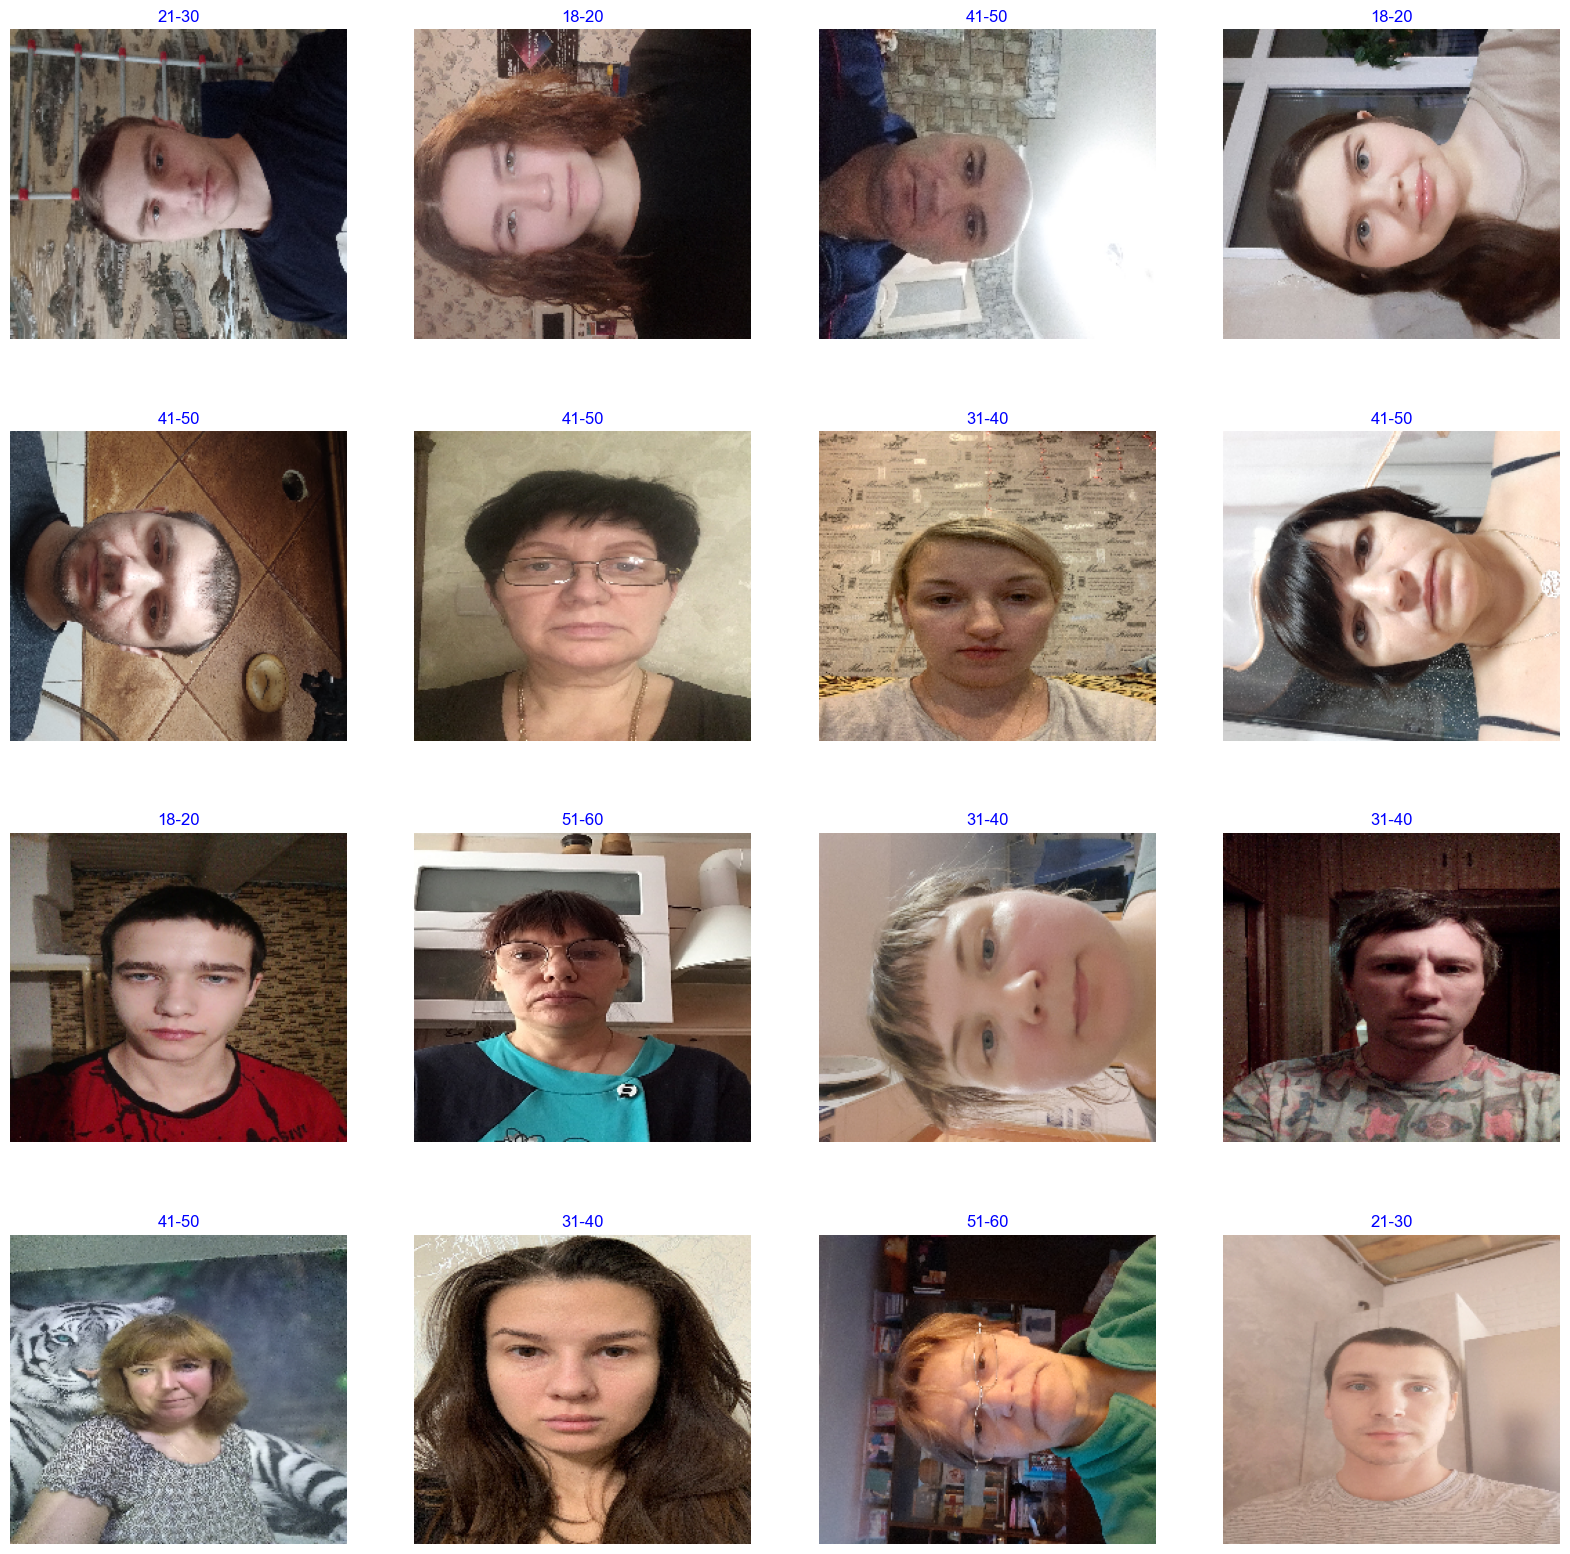

In [12]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

**Model building**

The model architecture have been developed as following:

First-> for the convolutional layers and pooling layers the EfficientNetB3 architecture is used

(feature extraction)

Second-> the data will be normalized for more efficient training of data and faster processing.

Third-> a fully connected layer (dens) will be applied with 256 neurons.

Forth-> a dropout function will be applied with a value of 0.4 to avoid overfitting

Finally-> the output layer (fully connected layer(dens)) will be appied with 5 neurons (numbeer of calsses).

In [13]:
img_shape = (img_size[0],img_size[1],3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet' ,
                                                               input_shape = img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, activation = 'relu'),
    Dropout(0.4),
    Dense(num_class , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()



43941136/43941136 [==============================] - 28s 1us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                      

**Model Training**

In [14]:
history = model.fit(x= train_gen , epochs = 10 , validation_data = valid_gen)

Epoch 1/10


8/8 [==============================] - 82s 6s/step - loss: 2.6509 - accuracy: 0.1760 - val_loss: 4.2926 - val_accuracy: 0.0833
Epoch 2/10
8/8 [==============================] - 35s 4s/step - loss: 1.0770 - accuracy: 0.6000 - val_loss: 5.5640 - val_accuracy: 0.0833
Epoch 3/10
8/8 [==============================] - 35s 4s/step - loss: 0.5962 - accuracy: 0.7920 - val_loss: 5.7870 - val_accuracy: 0.0833
Epoch 4/10
8/8 [==============================] - 36s 4s/step - loss: 0.3835 - accuracy: 0.8880 - val_loss: 5.7948 - val_accuracy: 0.0833
Epoch 5/10
8/8 [==============================] - 34s 4s/step - loss: 0.1559 - accuracy: 0.9360 - val_loss: 5.3357 - val_accuracy: 0.0833
Epoch 6/10
8/8 [==============================] - 39s 5s/step - loss: 0.1085 - accuracy: 0.9600 - val_loss: 5.0751 - val_accuracy: 0.1667
Epoch 7/10
8/8 [==============================] - 33s 4s/step - loss: 0.1539 - accuracy: 0.9680 - val_loss: 4.8558 - val_accuracy: 0.1667
Epoch 8/10
8/8 [================

**Model Performance Visualization**

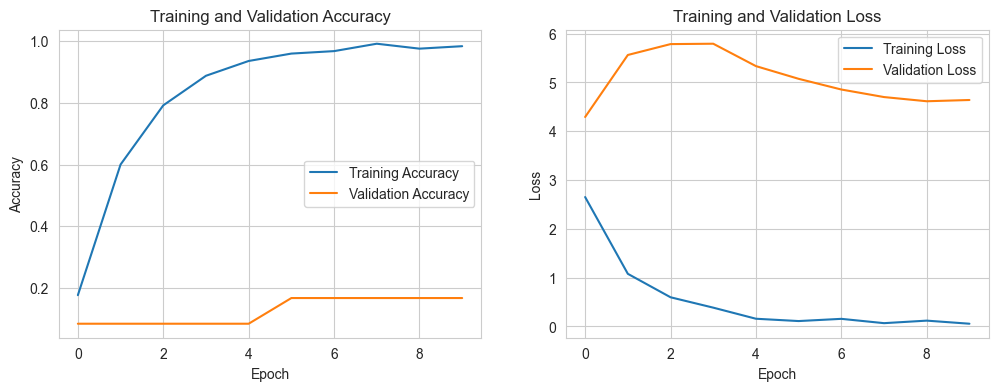

In [15]:
# Assuming 'history' is the object returned by model.fit

# Plot training and validation accuracy over epochs
plt.figure(figsize=(12, 4))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

**Model Evaluation**

In [16]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 40)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 40)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 1s 3ms/step - loss: 3.6131 - accuracy: 0.1538
Train Loss:  0.04669922590255737
Train Accuracy:  0.9919999837875366
----------------------------------------
Validation Loss:  4.640916347503662
Validation Accuracy:  0.1666666716337204
----------------------------------------
Test Loss:  3.61310076713562
Test Accuracy:  0.1538461595773697


**Measurment of the Model Accuracy and Viewing of Classification report**

In [17]:
# Assuming model and test_images, test_labels are defined

# Make predictions on the test set
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds,axis=1)

# Display classification report
print("Classification Report:\n", classification_report(test_gen.classes, y_pred))

# Display confusion matrix
conf_matrix = confusion_matrix(test_gen.classes, y_pred)
print("Confusion Matrix:\n", conf_matrix)

#claucalting TP,TF,NP, and NF values
total_TP = 0
total_TN = 0
total_FP = 0
total_FN = 0

for i in range(conf_matrix.shape[0]):
    TP = conf_matrix[i, i]  # True Positives (diagonal element)

    # False Positives: sum of column i excluding TP
    FP = np.sum(conf_matrix[:, i]) - TP

    # False Negatives: sum of row i excluding TP
    FN = np.sum(conf_matrix[i, :]) - TP

    # True Negatives: Everything else outside the particular row and column
    TN = np.sum(conf_matrix) - TP - FP - FN

    total_TP += TP
    total_TN += TN
    total_FP += FP
    total_FN += FN

# Calculate and print accuracy, precision, recall, and F1-score
accuracy = (total_TP + total_TN)/(total_TP + total_TN + total_FN + total_FP)
precision = total_TP / (total_TP + total_FP)
recall = TP / (total_TP + total_FN)
f1_score = 2 * (precision * recall) / (precision + recall)


'''print("   T\t F\nT ",total_TP,"\t",total_TN)
print("\nF ",total_FN,"\t",total_FP)'''
print("Accuracy:", accuracy * 100)
print("Precision:", precision *100)
print("Recall:", recall *100)
print("F1-Score:", f1_score *100)


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.25      0.67      0.36         3
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2

    accuracy                           0.15        13
   macro avg       0.05      0.13      0.07        13
weighted avg       0.06      0.15      0.08        13

Confusion Matrix:
 [[0 3 0 0 0]
 [1 2 0 0 0]
 [2 1 0 0 0]
 [0 1 1 0 0]
 [1 1 0 0 0]]
Accuracy: 66.15384615384615
Precision: 15.384615384615385
Recall: 0.0
F1-Score: 0.0


**Confusion Matrix**

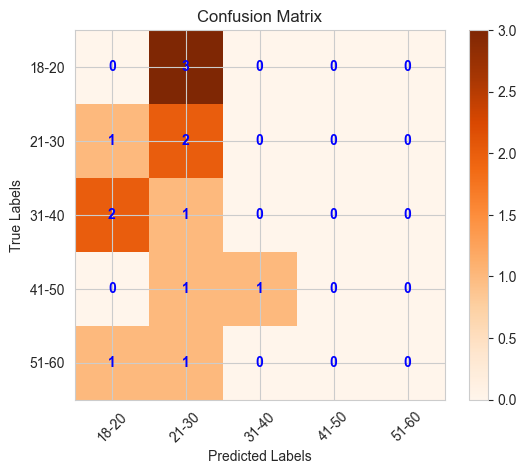

In [18]:
# Define class names
class_names = ['18-20','21-30','31-40','41-50','51-60']

# Plot the confusion matrix with numbers
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title('Confusion Matrix')
plt.colorbar()

# Add class names to ticks
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add numbers to cells
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='Blue', fontweight='bold')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [19]:
from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/vision project/AgeClassificationModel.hdf5')